[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

#Compare H3K27ac Chip-seq fold enrichment at early/sustained/late Etv2 ChIP-seq sites during MEF reprogramming
by Erik Skie

In [ ]:
start_time0 <- Sys.time()

## Set Environment

In [ ]:
%load_ext rpy2.ipython
#To load R

### Install packages

In [ ]:
%%R
system('apt-get -q install libgsl-dev', intern = TRUE)
if (!requireNamespace("BiocManager", quietly = TRUE))
  install.packages("BiocManager")
BiocManager::install(c(
  'SummarizedExperiment', 'BiocParallel', 'ComplexHeatmap', 
  'rtracklayer', 'EnrichedHeatmap'), Ncpus = 2)
install.packages(c('devtools', 'gplots', 'circlize', 'dplyr'))


### Import packages

In [ ]:
from sinfo import sinfo
import pandas as pd

In [ ]:
%%R
library(BiocParallel)
register(MulticoreParam(2))
library(SummarizedExperiment)
library(gplots)
library(circlize)
library(dplyr)
library(ComplexHeatmap)
library(EnrichedHeatmap)
library(rtracklayer)

## Download `fold enrichment` bigwig files



In [ ]:
%%R
peaks <- readRDS(gzcon(url('https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/all_Etv2_peaks.rds')))
peaks <- peaks[peaks$group[, 'MEF_Dox_d1_Etv2'] | peaks$group[, 'MEF_Dox_d7_Etv2']]
bw_files = c(Mef_Brg1_KO_H3K27Acl = 'https://s3.msi.umn.edu/skiex003/datasets/dataset=AlverBrg1ChIP-seq_version=20201005a/ChIP-seq_Smarca4_H3K27Acl_FE_V2.bw', 
             MEF_WT_H3K27Acl = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_NoDox_d0_H3K27ac_FE.bw')
H3K27Acl_peaks = lapply(bw_files, function(bw_files) import.bw(bw_files))
local_bw_files <- gsub('https://s3.msi.umn.edu/', './', bw_files)
commands <- sprintf('wget -x -c -nH %s', bw_files)
lapply(commands, function(command) system(command))
file.exists(local_bw_files)

[1] TRUE TRUE


## A Heatmap of H3K27ac ChIP-seq signals over early/late/sustained Etv2 ChIP-seq peaks in MEF

### Select the sustained Etv2 ChIP-seq peaks that are present in both D1 and D7 post induction

In [ ]:
%%R
expandedpeaks <- peaks[peaks$group[, 'MEF_Dox_d1_Etv2'] | peaks$group[, 'MEF_Dox_d7_Etv2']]
cat(sprintf('number of early peaks in: %d\n', sum(expandedpeaks$group[, 'MEF_Dox_d1_Etv2'] & !expandedpeaks$group[, 'MEF_Dox_d7_Etv2'])))
cat(sprintf('number of late peaks in: %d\n', sum(!expandedpeaks$group[, 'MEF_Dox_d1_Etv2'] & expandedpeaks$group[, 'MEF_Dox_d7_Etv2'])))
cat(sprintf('number of sustained peaks in: %d\n', sum(expandedpeaks$group[, 'MEF_Dox_d1_Etv2'] & expandedpeaks$group[, 'MEF_Dox_d7_Etv2'])))

number of early peaks in: 111167
number of late peaks in: 4222
number of sustained peaks in: 12170


### prepare normalized matrix for enriched heatmap

In [ ]:
%%R
extend <- 1000
w <- 50
smooth <- FALSE
target_ratio <- 0.2
mc.cores <- 2
target_width <- width(expandedpeaks)[1]
cat(sprintf('# peaks : %d\n', length(expandedpeaks)))
cat(sprintf('target width : %d\n', target_width))

# peaks : 127559
target width : 200


In [ ]:
%%R 
mat <- lapply(local_bw_files, function(bw_file){
  cvg <- rtracklayer::import(
    bw_file, 
    which = trim(GenomicRanges::reduce(resize(expandedpeaks, fix = 'center', width = target_width + extend * 2)))
  )  # returned as a GRanges object
  normalizeToMatrix(
    cvg, 
    expandedpeaks, 
    extend = extend, 
    value_column = 'score', 
    mean_mode = 'w0', 
    w = w, 
    smooth = smooth, 
    target_ratio = target_ratio
  )
})

### color scheme of heatmap

In [ ]:
%%R
group_cols <- c(
  'Mef_Brg1_KO_H3K27Acl' = 'darkgreen',
  'MEF_WT_H3K27Acl' = 'darkgreen'
)
col_fun <- lapply(1:length(mat), function(i) colorRamp2(quantile(mat[[i]], c(0.005, 0.995)), c('white', group_cols[i])))
names(col_fun) <- names(bw_files)

### generate heatmap

R[write to console]: `use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` arugment by explicitly setting
TRUE/FALSE to it. Set `ht_opt$message = FALSE` to turn off this
message.

R[write to console]: `use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` arugment by explicitly setting
TRUE/FALSE to it. Set `ht_opt$message = FALSE` to turn off this
message.



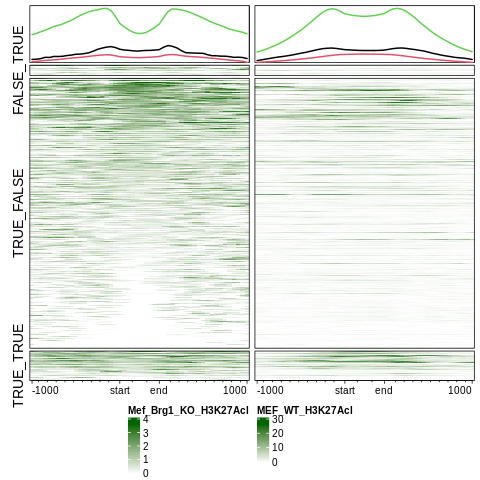

In [ ]:
%%R 
i <- 1:length(expandedpeaks)
sp <- factor(sprintf('%s_%s', expandedpeaks$group[, 'MEF_Dox_d1_Etv2'], expandedpeaks$group[, 'MEF_Dox_d7_Etv2']))
ta <- HeatmapAnnotation(
  enriched = anno_enriched(gp = gpar(lty = 1, lwd = 2, col = 1:nlevels(sp)), 
  axis_param = list(facing = 'inside', at = -1000))
)
h <- EnrichedHeatmap(
  mat[['Mef_Brg1_KO_H3K27Acl']][i, ], 
  col = col_fun[['Mef_Brg1_KO_H3K27Acl']], 
  split = sp[i], 
  name = 'Mef_Brg1_KO_H3K27Acl', 
  top_annotation = ta, 
  pos_line = FALSE
)
ss <- c(
  'MEF_WT_H3K27Acl'
)
for (s in ss[ss %in% names(bw_files)]){
  h <- h + EnrichedHeatmap(mat[[s]][i, ], col = col_fun[[s]], name = s, top_annotation = ta, pos_line = FALSE)
}
options(repr.plot.width = 10, repr.plot.height = 10)
draw(h, heatmap_legend_side = 'bottom')

## A Heatmap of H3K27ac ChIP-seq signals over early/late/sustained Etv2 Chip-seq peaks in MEF split by early and late 

### seperating Etv2 peaks by early and late

In [ ]:
%%R
expandedpeaksD1 <- peaks[peaks$group[, 'MEF_Dox_d1_Etv2']]
expandedpeaksD7 <- peaks[peaks$group[, 'MEF_Dox_d7_Etv2']]
expandedpeaks = list(expandedpeaksD1, expandedpeaksD7)
cat(sprintf('number of early peaks in D1: %d\n', sum(expandedpeaksD1$group[, 'MEF_Dox_d1_Etv2'] & !expandedpeaksD1$group[, 'MEF_Dox_d7_Etv2'])))
cat(sprintf('number of late peaks in D1: %d\n', sum(!expandedpeaksD1$group[, 'MEF_Dox_d1_Etv2'] & expandedpeaksD1$group[, 'MEF_Dox_d7_Etv2'])))
cat(sprintf('number of sustained peaks in D1: %d\n', sum(expandedpeaksD1$group[, 'MEF_Dox_d1_Etv2'] & expandedpeaksD1$group[, 'MEF_Dox_d7_Etv2'])))
cat(sprintf('number of early peaks in D7: %d\n', sum(expandedpeaksD7$group[, 'MEF_Dox_d1_Etv2'] & !expandedpeaksD7$group[, 'MEF_Dox_d7_Etv2'])))
cat(sprintf('number of late peaks in D7: %d\n', sum(!expandedpeaksD7$group[, 'MEF_Dox_d1_Etv2'] & expandedpeaksD7$group[, 'MEF_Dox_d7_Etv2'])))
cat(sprintf('number of sustained peaks in D7: %d\n', sum(expandedpeaksD7$group[, 'MEF_Dox_d1_Etv2'] & expandedpeaksD7$group[, 'MEF_Dox_d7_Etv2'])))

number of early peaks in D1: 111167
number of late peaks in D1: 0
number of sustained peaks in D1: 12170
number of early peaks in D7: 0
number of late peaks in D7: 4222
number of sustained peaks in D7: 12170


### prepare normalized matrix for `EnrichedHeatmap`

In [ ]:
%%R
extend <- 1000
w <- 50
smooth <- FALSE
target_ratio <- 0.2
mc.cores <- 2
target_width <- width(expandedpeaks[[1]])[1]
peaknumbers = c('Mef_Brg1_KO_H3K27Acl_D1' = length(expandedpeaksD1), 
                'Mef_Brg1_KO_H3K27Acl_D7' = length(expandedpeaksD7), 
                'MEF_WT_H3K27Acl_D1' = length(expandedpeaksD1), 
                'MEF_WT_H3K27Acl_D7' = length(expandedpeaksD7))
cat(sprintf('# peaks D1: %d\n', length(expandedpeaksD1)))
cat(sprintf('target width D1: %d\n', target_width))
cat(sprintf('# peaks D7: %d\n', length(expandedpeaksD7)))
cat(sprintf('target width D7: %d\n', target_width))

# peaks D1: 123337
target width D1: 200
# peaks D7: 16392
target width D7: 200


In [ ]:
%%R 
mat <- lapply(local_bw_files, function(bw_file){
    lapply(expandedpeaks, function(expandedpeaks){
        cvg <- rtracklayer::import(
        bw_file, 
        which = trim(GenomicRanges::reduce(resize(expandedpeaks, fix = 'center', width = target_width + extend * 2)))
        )  # returned as a GRanges object
        normalizeToMatrix(
        cvg, 
        expandedpeaks, 
        extend = extend, 
        value_column = 'score', 
        mean_mode = 'w0', 
        w = w, 
        smooth = smooth, 
        target_ratio = target_ratio
        )
    })
})

In [ ]:
%%R
#mat
mat2 = list('Mef_Brg1_KO_H3K27Acl_D1' = mat$Mef_Brg1_KO_H3K27Acl[[1]],
         'Mef_Brg1_KO_H3K27Acl_D7' = mat$Mef_Brg1_KO_H3K27Acl[[2]],
         'MEF_WT_H3K27Acl_D1' = mat$MEF_WT_H3K27Acl[[1]],
         'MEF_WT_H3K27Acl_D7' = mat$MEF_WT_H3K27Acl[[2]])

### color scheme of heatmap

In [ ]:
%%R
group_cols <- c(
  'Mef_Brg1_KO_H3K27Acl_D1' = 'darkgreen',
  'Mef_Brg1_KO_H3K27Acl_D7' = 'darkgreen',
  'MEF_WT_H3K27Acl_D1' = 'darkgreen',
  'MEF_WT_H3K27Acl_D7' = 'darkgreen'
)
col_fun <- lapply(1:length(mat2), function(i) colorRamp2(quantile(mat2[[i]], c(0.005, 0.995)), c('white', group_cols[i])))
names(col_fun) <- c('Mef_Brg1_KO_H3K27Acl_D1', 'Mef_Brg1_KO_H3K27Acl_D7', 'MEF_WT_H3K27Acl_D1', 'MEF_WT_H3K27Acl_D7')

In [ ]:
%%R
#col_fun[['Mef_Brg1_KO_H3K27Acl_D1']]
#mat2[['Mef_Brg1_KO_H3K27Acl_D1']]
expandedpeaks[[1]]$group

### generate heatmap

R[write to console]: `use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` arugment by explicitly setting
TRUE/FALSE to it. Set `ht_opt$message = FALSE` to turn off this
message.

R[write to console]: `use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` arugment by explicitly setting
TRUE/FALSE to it. Set `ht_opt$message = FALSE` to turn off this
message.

R[write to console]: `use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` arugment by explicitly setting
TRUE/FALSE to it. Set `ht_opt$message = FALSE` to turn off this
message.

R[write to console]: `use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` arugment by explicitly setting
TRUE/FALSE to it. Set `ht_opt$message = FALSE` to turn off this
message.



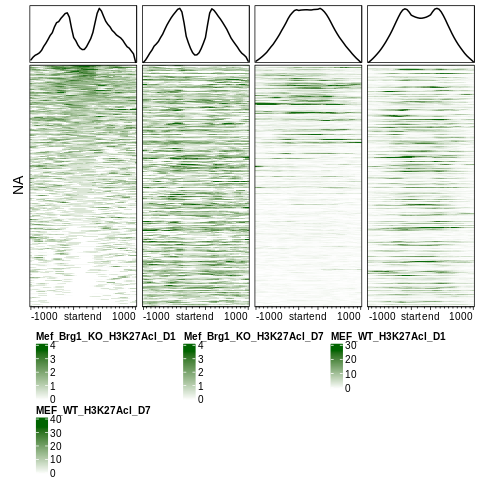

In [ ]:
%%R 
i <- 1:peaknumbers['Mef_Brg1_KO_H3K27Acl_D7']
sp <- factor(sprintf('%s_%s', expandedpeaks[1]$group[, 'MEF_Dox_d1_Etv2'], expandedpeaks[1]$group[, 'MEF_Dox_d7_Etv2']))
ta <- HeatmapAnnotation(
  enriched = anno_enriched(gp = gpar(lty = 1, lwd = 2, col = 1:nlevels(sp)), 
  axis_param = list(facing = 'inside', at = -1000))
)
h <- EnrichedHeatmap(
  mat2[['Mef_Brg1_KO_H3K27Acl_D1']][i, ], 
  col = col_fun[['Mef_Brg1_KO_H3K27Acl_D1']], 
  split = sp[i], 
  name = 'Mef_Brg1_KO_H3K27Acl_D1', 
  top_annotation = ta, 
  pos_line = FALSE
)
ss <- c(
  'Mef_Brg1_KO_H3K27Acl_D7',
  'MEF_WT_H3K27Acl_D1',
  'MEF_WT_H3K27Acl_D7'
)
for (s in ss[ss %in% c('Mef_Brg1_KO_H3K27Acl_D1', 'Mef_Brg1_KO_H3K27Acl_D7', 'MEF_WT_H3K27Acl_D1', 'MEF_WT_H3K27Acl_D7')]){
  h <- h + EnrichedHeatmap(mat2[[s]][1:peaknumbers['Mef_Brg1_KO_H3K27Acl_D7'], ], col = col_fun[[s]], name = s, top_annotation = ta, pos_line = FALSE)
}
options(repr.plot.width = 10, repr.plot.height = 10)
draw(h, heatmap_legend_side = 'bottom')

# Session Information

## R Session Information

In [ ]:
%%R
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas/liblapack.so.3

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      parallel  stats4    tools     stats     graphics  grDevices
 [8] utils     datasets  methods   base     

other attached packages:
 [1] rtracklayer_1.48.0          EnrichedHeatmap_1.18.2     
 [3] ComplexHeatmap_2.4.3        dplyr_1.0.2                
 [5] circlize_0.4.10             gplots_3.1.0               
 [7] SummarizedExperiment_1.18.2 DelayedA

## Python Session Information

In [ ]:
sinfo()

-----
pandas      1.1.2
sinfo       0.3.1
-----
IPython             5.5.0
jupyter_client      5.3.5
jupyter_core        4.6.3
notebook            5.3.1
-----
Python 3.6.9 (default, Jul 17 2020, 12:50:27) [GCC 8.4.0]
Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic
2 logical CPU cores, x86_64
-----
Session information updated at 2020-10-13 13:08


## Run time

Sys.time() - start_time0